### 데이터 준비 및 환경 설정

In [1]:
import os
import pandas as pd
sp_data_dict = dict()
for file_name in os.listdir("../../데이터/주가데이터"):
    sp_data = pd.read_csv("../../데이터/주가데이터/" + file_name,
                          parse_dates = ['Date'])
    stock_name = file_name.replace('.csv', '')
    sp_data_dict[stock_name] = sp_data

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
sns.set()
%matplotlib inline
rcParams['font.family'] = 'Malgun Gothic'
rcParams['axes.unicode_minus'] = False

### EOM 지수

#### 분석용 데이터 준비

In [4]:
import numpy as np
eom_data_dict = dict()
for stock_name in sp_data_dict.keys():
    eom_data = sp_data_dict[stock_name].copy()
    high_price = eom_data["High"].values
    low_price = eom_data["Low"].values
    volume = eom_data["Volume"].values
    MM = ((high_price[1:] + low_price[1:]) - (high_price[:-1] + low_price[:-1])) / 2
    BR = (volume[1:] / 10000) / (high_price[1:] - low_price[1:])
    EOM = MM / BR
    eom_data.drop(0, inplace = True)
    eom_data["EOM"] = EOM
    eom_data["EOM_5"] = eom_data["EOM"].rolling(5).mean()
    eom_data["EOM_10"] = eom_data["EOM"].rolling(10).mean()
    eom_data["EOM_20"] = eom_data["EOM"].rolling(20).mean()
    eom_data_dict[stock_name] = eom_data

#### 전략 구현 및 검증

In [5]:
def ror_using_EOM(eom_data_dict, EOM_col):
    ror_list = []
    for stock_name in eom_data_dict.keys():
        eom_data = eom_data_dict[stock_name]
        EOM = eom_data[EOM_col].values
        buy_point_list = (EOM[1:] > 0) & (EOM[:-1] <= 0)
        buy_point_list = np.insert(buy_point_list, 0, False)
        buy_point_list = eom_data.index[buy_point_list]

        sell_point_list = (EOM[1:] < 0) & (EOM[:-1] >= 0)
        sell_point_list = np.insert(sell_point_list, 0, False)
        sell_point_list = eom_data.index[sell_point_list]
        for bp in buy_point_list:
            if (sum(bp < sell_point_list) > 0) and (bp + 1 <= eom_data.index[-1]):
                buy_price = eom_data.loc[bp + 1, "Close"]
                sp = sell_point_list[sell_point_list > bp][0] + 1
                if sp <= eom_data.index[-1]:
                    sell_price = eom_data.loc[sp, "Close"]
                    ror = (sell_price - buy_price) / buy_price * 100
                    ror_list.append(ror)
            else:
                break
    return np.array(ror_list)

In [8]:
EOM_1_ror = ror_using_EOM(eom_data_dict, "EOM")
EOM_5_ror = ror_using_EOM(eom_data_dict, "EOM_5")
EOM_10_ror = ror_using_EOM(eom_data_dict, "EOM_10")
EOM_20_ror = ror_using_EOM(eom_data_dict, "EOM_20")

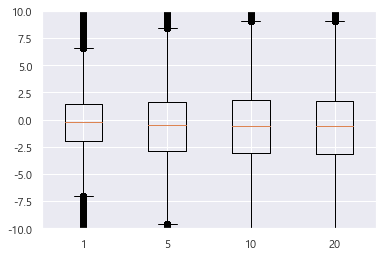

In [9]:
plt.boxplot([EOM_1_ror, EOM_5_ror, EOM_10_ror, EOM_20_ror])
plt.xticks([1, 2, 3, 4], [1, 5, 10, 20])
plt.ylim(-10, 10)
plt.show()

In [10]:
result = pd.concat([pd.Series(EOM_1_ror).describe(),
                    pd.Series(EOM_5_ror).describe(),
                    pd.Series(EOM_10_ror).describe(),
                    pd.Series(EOM_20_ror).describe()], axis = 1)
display(result.round(3))

,0,1,2,3
count,1037616.000,447208.000,312920.000,214228.000
mean,0.176,0.272,0.518,0.679
std,5.646,8.321,10.305,12.343
min,-90.295,-91.836,-71.042,-84.088
25%,-1.961,-2.857,-3.077,-3.175
50%,-0.218,-0.542,-0.571,-0.621
75%,1.444,1.641,1.765,1.729
max,664.131,588.158,857.627,1138.938


### RSI

#### 분석용 데이터 준비

In [13]:
rsi_data_dict = dict()
for stock_name in sp_data_dict.keys():
    rsi_data = sp_data_dict[stock_name][['Close']].copy()
    price = rsi_data["Close"].values
    rise = price[1:] - price[:-1]
    rise[rise < 0] = 0
    fall = price[:-1] - price[1:]
    fall[fall < 0] = 0
    
    rsi_data.drop(0, inplace = True)
    rsi_data["상승폭"] = rise
    rsi_data["하락폭"] = fall
    
    for n in [5, 10, 20]:
        sum_rise_n = rsi_data["상승폭"].rolling(n).sum()
        sum_fall_n = rsi_data["하락폭"].rolling(n).sum()
        rsi_data["RSI_" + str(n)] = sum_rise_n / (sum_rise_n + sum_fall_n)
    rsi_data_dict[stock_name] = rsi_data

#### 전략 1 구현 및 검증: RSI가 0.7 이상이면 매도, 0.3 미만이면 매수

In [14]:
result = pd.DataFrame()
for n in [5, 10, 20]:
    record = []
    for stock_name in rsi_data_dict.keys():
        rsi_data = rsi_data_dict[stock_name]
        RSI = rsi_data["RSI_" + str(n)].values
        
        buy_point_list = (RSI[1:] < 0.3) & (RSI[:-1] >= 0.3)
        buy_point_list = np.insert(buy_point_list, 0, False)
        buy_point_list = rsi_data.index[buy_point_list] 
        sell_point_list = (RSI[1:] >= 0.7) & (RSI[:-1] < 0.7)
        sell_point_list = np.insert(sell_point_list, 0, False)
        sell_point_list = rsi_data.index[sell_point_list] 
        
        for bp in buy_point_list:
            if (sum(bp < sell_point_list) > 0) and (bp + 1 <= rsi_data.index[-1]):
                buy_price = rsi_data.loc[bp + 1, "Close"]
                sp = sell_point_list[sell_point_list > bp][0] + 1
                if sp <= rsi_data.index[-1]:
                    sell_price = rsi_data.loc[sp, "Close"]
                    profit = (sell_price - buy_price) / buy_price * 100
                    record.append(profit)
            else:
                break
    result = pd.concat([result, pd.Series(record).describe()], axis = 1)

result.columns = [5, 10, 20]
display(result)

,5,10,20
count,410264.000000,228122.000000,99095.000000
mean,0.780008,1.666954,5.498085
std,9.163618,13.358169,21.958956
min,-96.281762,-96.525670,-95.512098
25%,-2.466793,-4.044118,-5.413053
50%,1.215067,2.531646,5.898123
75%,4.672897,7.809509,15.646259
max,622.311176,638.362760,900.113766


#### 전략 2 구현 및 검증: RSI가 0.5를 상향 돌파하면 매수, 하향 돌파하면 매도

In [15]:
result = pd.DataFrame()
for n in [5, 10, 20]:
    record = []
    for stock_name in rsi_data_dict.keys():
        rsi_data = rsi_data_dict[stock_name]
        RSI = rsi_data["RSI_" + str(n)].values
        
        buy_point_list = (RSI[1:] >= 0.5) & (RSI[:-1] < 0.5)
        buy_point_list = np.insert(buy_point_list, 0, False)
        buy_point_list = rsi_data.index[buy_point_list] 
        sell_point_list = (RSI[1:] < 0.5) & (RSI[:-1] >= 0.5)
        sell_point_list = np.insert(sell_point_list, 0, False)
        sell_point_list = rsi_data.index[sell_point_list] 
        
        for bp in buy_point_list:
            if (sum(bp < sell_point_list) > 0) and (bp + 1 <= rsi_data.index[-1]):
                buy_price = rsi_data.loc[bp + 1, "Close"]
                sp = sell_point_list[sell_point_list > bp][0] + 1
                if sp <= rsi_data.index[-1]:
                    sell_price = rsi_data.loc[sp, "Close"]
                    profit = (sell_price - buy_price) / buy_price * 100
                    record.append(profit)
            else:
                break
    result = pd.concat([result, pd.Series(record).describe()], axis = 1)

result.columns = [5, 10, 20]
display(result)

,5,10,20
count,492861.000000,340737.000000,237654.000000
mean,0.270583,0.573185,0.719588
std,8.730861,11.345124,14.149691
min,-93.047619,-90.734824,-90.075529
25%,-2.826380,-3.105023,-3.278689
50%,-0.586166,-0.620975,-0.705755
75%,1.449275,1.483051,1.343560
max,994.017094,975.498575,1241.880342


### MFI

#### 분석용 데이터 준비

In [16]:
mfi_data_dict = dict()
for stock_name in sp_data_dict.keys():
    mfi_data = sp_data_dict[stock_name][['Close']].copy()
    sp_data = sp_data_dict[stock_name]
    close_price = sp_data["Close"].values
    low_price = sp_data["Low"].values
    high_price = sp_data["High"].values
    volume = sp_data["Volume"].values
    
    MF = volume[1:] * (high_price[1:] + low_price[1:] + close_price[1:]) / 3
    PMF = np.zeros(len(MF))
    NMF = np.zeros(len(MF))
    
    PMF[close_price[1:] > close_price[:-1]] = MF[close_price[1:] > close_price[:-1]]
    NMF[close_price[1:] < close_price[:-1]] = MF[close_price[1:] < close_price[:-1]]
    
    mfi_data.drop(0, inplace = True)
    mfi_data["PMF"] = PMF
    mfi_data["NMF"] = NMF
    
    for n in [5, 10, 20]:
        PMF_n = mfi_data["PMF"].rolling(n).sum()
        NMF_n = mfi_data["NMF"].rolling(n).sum()
        MR = PMF_n / NMF_n
        mfi_data["MFI_" + str(n)] = MR / (1 + MR)
        
    mfi_data_dict[stock_name] = mfi_data

#### 전략 1 구현 및 검증: MFI가 0.7 이상이면 매도, 0.3 미만이면 매수

In [19]:
result = pd.DataFrame()
for n in [5, 10, 20]:
    record = []
    for stock_name in mfi_data_dict.keys():
        mfi_data = mfi_data_dict[stock_name]
        MFI = mfi_data["MFI_" + str(n)].values
        
        buy_point_list = (MFI[1:] < 0.3) & (MFI[:-1] >= 0.3)
        buy_point_list = np.insert(buy_point_list, 0, False)
        buy_point_list = mfi_data.index[buy_point_list] 
        sell_point_list = (MFI[1:] >= 0.7) & (MFI[:-1] < 0.7)
        sell_point_list = np.insert(sell_point_list, 0, False)
        sell_point_list = mfi_data.index[sell_point_list] 
        
        for bp in buy_point_list:
            if (sum(bp < sell_point_list) > 0) and (bp + 1 <= mfi_data.index[-1]):
                buy_price = mfi_data.loc[bp + 1, "Close"]
                sp = sell_point_list[sell_point_list > bp][0] + 1
                if sp <= mfi_data.index[-1]:
                    sell_price = mfi_data.loc[sp, "Close"]
                    profit = (sell_price - buy_price) / buy_price * 100
                    record.append(profit)
            else:
                break
    result = pd.concat([result, pd.Series(record).describe()], axis = 1)

result.columns = [5, 10, 20]
display(result)

,5,10,20
count,382104.000000,207802.000000,91614.000000
mean,0.779309,1.513636,3.901375
std,9.452907,12.661257,17.820963
min,-95.197728,-94.395542,-96.027014
25%,-2.724640,-3.823529,-4.494382
50%,1.096892,2.077922,4.075691
75%,4.810997,7.389163,12.171227
max,547.479881,587.077308,643.178120


#### 전략 2 구현 및 검증: MFI가 0.5를 상향 돌파하면 매수, 하향 돌파하면 매도

In [20]:
result = pd.DataFrame()
for n in [5, 10, 20]:
    record = []
    for stock_name in mfi_data_dict.keys():
        mfi_data = mfi_data_dict[stock_name]
        MFI = mfi_data["MFI_" + str(n)].values
        
        buy_point_list = (MFI[1:] >= 0.5) & (MFI[:-1] < 0.5)
        buy_point_list = np.insert(buy_point_list, 0, False)
        buy_point_list = mfi_data.index[buy_point_list] 
        sell_point_list = (MFI[1:] < 0.5) & (MFI[:-1] >= 0.5)
        sell_point_list = np.insert(sell_point_list, 0, False)
        sell_point_list = mfi_data.index[sell_point_list] 
        
        for bp in buy_point_list:
            if (sum(bp < sell_point_list) > 0) and (bp + 1 <= mfi_data.index[-1]):
                buy_price = mfi_data.loc[bp + 1, "Close"]
                sp = sell_point_list[sell_point_list > bp][0] + 1
                if sp <= mfi_data.index[-1]:
                    sell_price = mfi_data.loc[sp, "Close"]
                    profit = (sell_price - buy_price) / buy_price * 100
                    record.append(profit)
            else:
                break
    result = pd.concat([result, pd.Series(record).describe()], axis = 1)

result.columns = [5, 10, 20]
display(result)

,5,10,20
count,471501.000000,314553.000000,205874.000000
mean,0.323786,0.648010,0.963174
std,9.199380,12.528929,16.575112
min,-85.443291,-85.283546,-90.828829
25%,-2.954577,-3.362369,-3.793031
50%,-0.550459,-0.612445,-0.699301
75%,1.666667,1.837270,1.867484
max,694.736842,1322.222222,1011.111111
